# Practical Usage of Lava w/ custom input from the lab

The input data from the lab used in this example consists of a sequence of timestamps where a specific neuron fired. The data is stored in a csv file, where each value is a timestamp (in milliseconds). 

Thus, the input layer only requires 1 connection at each timestep. We will assume the network contains 5 neurons for the sake of this example.

Let's start by defining the middle layer, the 2-layered feed-forward network of LIF neurons

In [10]:
from lava.proc.lif.process import LIF
from lava.proc.dense.process import Dense

LIF?

Init signature: LIF(*args, **kwargs)
Docstring:     
Leaky-Integrate-and-Fire (LIF) neural Process.

LIF dynamics abstracts to:
u[t] = u[t-1] * (1-du) + a_in         # neuron current
v[t] = v[t-1] * (1-dv) + u[t] + bias  # neuron voltage
s_out = v[t] > vth                    # spike if threshold is exceeded
v[t] = 0                              # reset at spike

Parameters
----------
shape : tuple(int)
    Number and topology of LIF neurons.
u : float, list, numpy.ndarray, optional
    Initial value of the neurons' current.
v : float, list, numpy.ndarray, optional
    Initial value of the neurons' voltage (membrane potential).
du : float, optional
    Inverse of decay time-constant for current decay. Currently, only a
    single decay can be set for the entire population of neurons.
dv : float, optional
    Inverse of decay time-constant for voltage decay. Currently, only a
    single decay can be set for the entire population of neurons.
bias_mant : float, list, numpy.ndarray, optiona

In [11]:
# Define the number of neurons in each LIF Layer
n1 = 2   # Let's create a simple program with only 1 LIF layer

In [12]:
import numpy as np

# Create Processes
lif1 = LIF(shape=(n1,),  # There are 2 neurons
           vth=5,  # TODO: Verify these initial values
           v=0,
           dv=0.07,    # Inverse of decay time-constant for voltage decay
           du=0.2,  # Inverse of decay time-constant for current decay
           bias_mant=0,
           bias_exp=0,
           name="lif1")

Let's take a look at the ports and connections of the middle layer:

In [13]:
for proc in [lif1]:
    for port in proc.in_ports:
        print(f"Proc: {proc.name:<5} Port Name: {port.name:<5} Size: {port.size}")
    for port in proc.out_ports:
        print(f"Proc: {proc.name:<5} Port Name: {port.name:<5} Size: {port.size}")

Proc: lif1  Port Name: a_in  Size: 2
Proc: lif1  Port Name: s_out Size: 2


After verifying the input and output Ports of the middle layer, we can connect the network to complete the LIF-Dense-LIF structure

## Create the Custom Input Layer

### Define function to read the input data from the csv file and generate the corresponding spike events

In [14]:
import pandas as pd

def read_spike_events(file_path: str):
    """Reads the spike events from the input file and returns them as a numpy array

    Args:
        file_path (str): name of the file containing the spike events
    """
    spike_events = []

    try:
        # Read the spike events from the file
        df = pd.read_csv(file_path, header=None)

        # Detect errors
        if df.empty:
            raise Exception("The input file is empty")

        # Convert the scientific notation values to integers if any exist
        df = df.applymap(lambda x: int(float(x)) if (isinstance(x, str) and 'e' in x) else x)

        # Convert the dataframe to a numpy array
        spike_events = df.to_numpy()
        return spike_events[0]
    except Exception as e:
        print("Unable to read the input file: ", file_path, " error:", e)

    return spike_events

In [15]:
# Call the function to read the spike events
file_path = "./canal60.csv"
spike_events = read_spike_events(file_path)
print("Spike events: ", spike_events.shape, spike_events[:10])

Spike events:  (289,) [104000. 124000. 135000. 171000. 177000. 184000. 190000. 194000. 200000.
 200000.]


Define the SpikeEvent Generator Interface

In [16]:
from lava.magma.core.process.process import AbstractProcess
from lava.magma.core.process.variable import Var
from lava.magma.core.process.ports.ports import OutPort

class SpikeEventGen(AbstractProcess):
    """Input Process that generates spike events based on the input file

    Args:
        shape (tuple): Shape of the output port
        file_name (str): Name of the file containing the spike events
    """
    def __init__(self, shape: tuple, spike_events: np.ndarray, name: str) -> None:
        super().__init__(name=name)
        self.s_out = OutPort(shape=shape)
        self.spike_events = Var(shape=spike_events.shape, init=spike_events)

Implement the `SpikeEventGenerator` Model

In [17]:
from lava.magma.core.model.py.model import PyLoihiProcessModel  # Processes running on CPU inherit from this class
from lava.magma.core.resources import CPU
from lava.magma.core.decorator import implements, requires
from lava.magma.core.sync.protocols.loihi_protocol import LoihiProtocol
from lava.magma.core.model.py.type import LavaPyType
from lava.magma.core.model.py.ports import PyOutPort

@implements(proc=SpikeEventGen, protocol=LoihiProtocol)
@requires(CPU)
class PySpikeEventGenModel(PyLoihiProcessModel):
    """Spike Event Generator Process implementation running on CPU (Python)
    Args:
    """
    s_out: PyOutPort = LavaPyType(PyOutPort.VEC_DENSE, float)   # IT IS POSSIBLE TO SEND FLOATS AFTER ALL
    spike_events: np.ndarray = LavaPyType(np.ndarray, np.ndarray)   # TODO: Check if we should keep it as a numpy array, or transform it to a list

    def __init__(self, proc_params) -> None:
        super().__init__(proc_params=proc_params)
        # print("spike events", self.spike_events.__str__())    # TODO: Check why during initialization the variable prints the class, while during run it prints the value
        self.curr_spike_idx = 0     # Index of the next spiking event to send
        self.virtual_time_step_interval = 1  # 1000    # Arbitrary time between time steps (in microseconds). This is not a real time interval (1000ms = 1s)
        self.init_offset = 100000 # 0              # Arbitrary offset to start the simulation (in microseconds)

    def run_spk(self) -> None:
        spike_data = np.zeros(self.s_out.shape) # Initialize the spike data to 0
        
        # Use random spikes to test it
        # spike_data[0] = np.random.random()  # Only 1 neuron is sending data (spikes)
        # self.curr_spike_idx += 1

        # Use the spike events from the file
        # print("spike events: ", self.spike_events[:5])
        # TODO: For now we are using the time_step as the time measurement that will simulate real-time activity. It would be better to have access to the running time
        
        #print("time step:", self.time_step)
        # If the current simulation time is greater than the next spike event, send a spike
        currTime = self.init_offset + self.time_step*self.virtual_time_step_interval
        if ( self.curr_spike_idx < len(self.spike_events) ) and currTime >= self.spike_events[self.curr_spike_idx]:
            spike_data[0] = 1.0   # Send a spike  (value corresponds to the punctual current of the spike event?)
            spike_data[1] = 0.0   # Send a spike  (value corresponds to the punctual current of the spike event?)
            print(f"sending spike event at time: {currTime}({self.time_step}) spike idx: {self.curr_spike_idx} spike time: {self.spike_events[self.curr_spike_idx]}")
            self.curr_spike_idx += 1

        # Send spikes
        # print("sending spike_data: ", spike_data, " at step: ", self.time_step)
        self.s_out.send(spike_data)

        # Stop the Process if there are no more spike events to send. (It will stop all the connected processes)
        # TODO: Should it be another process that stops the simulation? Such as the last LIF process
        # if self.curr_spike_idx >= 5: # len(self.spike_events):
        #    self.pause()


## Connect the Custom Input Layer to the middle layer

To define the connectivity between the `SpikeGenerator` and the first `LIF` population, we use another `Dense` Layer.

In [18]:
# Create the Input Process
spike_event_gen = SpikeEventGen(shape=(n1,), spike_events=spike_events, name="CustomInput")

# Instantiante a Dense Layer to connect the SpikeEventGen to the middle layer
dense_input = Dense(weights=np.eye(n1), name="DenseInput")     # 1-1 connectivity with the Middle Layer (should be a 2x2 matrix right now)
print("Dense Input Weights: ", dense_input.weights)

# Connect the SpikeEventGen to the Dense Layer
spike_event_gen.s_out.connect(dense_input.s_in)

# Connect the Dense_Input to the LIF1 Layer
dense_input.a_out.connect(lif1.a_in)

Dense Input Weights:  Variable: weights
    shape: (2, 2)
    init: [[1. 0.]
 [0. 1.]]
    shareable: True
    value: [[1. 0.]
 [0. 1.]]


### Take a look at the connections in the Input Layer

In [19]:
for proc in [spike_event_gen, dense_input, lif1]:
    for port in proc.in_ports:
        print(f"Proc: {proc.name:<5} Port Name: {port.name:<5} Size: {port.size}")
    for port in proc.out_ports:
        print(f"Proc: {proc.name:<5} Port Name: {port.name:<5} Size: {port.size}")

Proc: CustomInput Port Name: s_out Size: 2
Proc: DenseInput Port Name: s_in  Size: 2
Proc: DenseInput Port Name: a_out Size: 2
Proc: lif1  Port Name: a_in  Size: 2
Proc: lif1  Port Name: s_out Size: 2


Weights of the Input Dense Layer

In [20]:
dense_input.weights.get()

array([[1., 0.],
       [0., 1.]])

### Record Internal Vars over time
To record the evolution of the internal variables over time, we need a `Monitor`. For this example, we want to record the membrane potential of the `LIF` Layer, hence we need 1 `Monitors`.

We can define the `Var` that a `Monitor` should record, as well as the recording duration, using the `probe` function

In [21]:
from lava.proc.monitor.process import Monitor

monitor_lif1_v = Monitor()
monitor_lif1_u = Monitor()

num_steps = 300000     # TODO: Check the number of steps to run the simulation for

# Connect the monitors to the variables we want to monitor
monitor_lif1_v.probe(lif1.v, num_steps)
monitor_lif1_u.probe(lif1.u, num_steps)

## Execution
Now that we have defined the network, we can execute it. We will use the `run` function to execute the network.

### Run Configuration and Conditions

In [22]:
from lava.magma.core.run_conditions import RunContinuous, RunSteps
from lava.magma.core.run_configs import Loihi1SimCfg

# run_condition = RunContinuous()   # TODO: Change to this one
run_condition = RunSteps(num_steps=num_steps)
run_cfg = Loihi1SimCfg(select_tag="floating_pt")   # TODO: Check why we need this select_tag="floating_pt"

### Execute

In [23]:
lif1.run(condition=run_condition, run_cfg=run_cfg)

### Retrieve recorded data

In [24]:
data_lif1_v = monitor_lif1_v.get_data()
data_lif1_u = monitor_lif1_u.get_data()

data_lif1 = data_lif1_v.copy()
data_lif1["lif1"]["u"] = data_lif1_u["lif1"]["u"]   # Merge the dictionaries to contain both voltage and current


In [25]:
data_lif1

{'lif1': {'v': array([[0., 0.],
         [0., 0.],
         [0., 0.],
         ...,
         [0., 0.],
         [0., 0.],
         [0., 0.]]),
  'u': array([[0., 0.],
         [0., 0.],
         [0., 0.],
         ...,
         [0., 0.],
         [0., 0.],
         [0., 0.]])}}

In [26]:
# Check the shape to verify if it is printing the voltage for every step
len(data_lif1['lif1']['v'])     # Indeed, there are 300 values (same as the number of steps we ran the simulation for)

3000

### Plot the recorded data

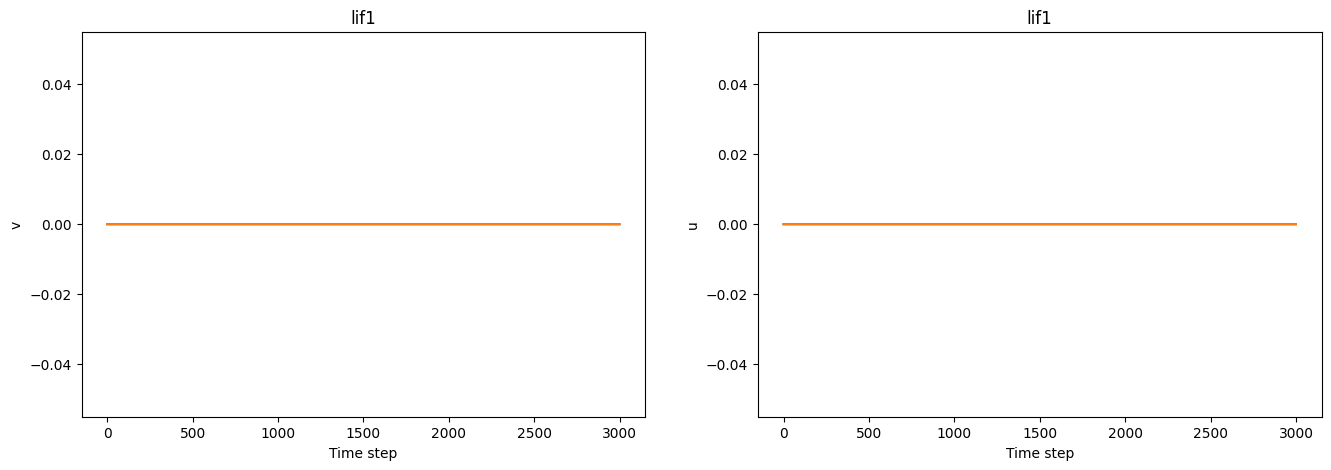

In [27]:
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt

# Create a subplot for each monitored variable
fig = plt.figure(figsize=(16, 5))
ax0 = fig.add_subplot(121)
ax0.set_title('Voltage (V) / time step')
ax1 = fig.add_subplot(122)
ax1.set_title('Current (U) / time step')

# Plot the data
monitor_lif1_v.plot(ax0, lif1.v)
monitor_lif1_u.plot(ax1, lif1.u)


### Find the time step where the Voltage got to 1/e of the maximum value

In [28]:
voltage_vals = data_lif1['lif1']['v']

v_max = 0
stimuli_start = 0
stimuli_end = 0
for (idx, v) in enumerate(voltage_vals):
    v0, v1 = v
    if v0 > v_max:  # Found the stimulation point
        v_max = v0
        stimuli_start = idx
    else:
        if v_max > 0:   # The stimulation was already found -> Exponential decay
            if v0 <= v_max / np.e:  # Found the timestep when the voltage is 1/e of the maximum
                stimuli_end = idx
                break
        else:   # The stimulation was not found yet
            continue


print(f"Stimuli start: {stimuli_start} Stimuli end: {stimuli_end} Voltage max: {v_max}")

Stimuli start: 0 Stimuli end: 0 Voltage max: 0


### Find the time step where the Current got to 1/e of the maximum value

In [29]:
current_vals = data_lif1['lif1']['u']

u_max = 0
stimuli_start = 0
stimuli_end = 0
for (idx, u) in enumerate(current_vals):
    u0, u1 = u
    if u0 > u_max:  # Found the stimulation point
        u_max = u0
        stimuli_start = idx
    else:
        if u_max > 0:   # The stimulation was already found -> Exponential decay
            if u0 <= u_max / np.e:  # Found the timestep when the current is 1/e of the maximum
                stimuli_end = idx
                break
        else:   # The stimulation was not found yet
            continue


print(f"Stimuli start: {stimuli_start} Stimuli end: {stimuli_end} Current max: {u_max}")

Stimuli start: 0 Stimuli end: 0 Current max: 0


## Stop the Runtime

In [30]:
lif1.stop()